# Proper Orthogonal Decomposition (POD) for Structural Mechanics
inspired from Buljak, V. (2012). Inverse Analyses with Model Reduction Proper Orthogonal Decomposition in Structural Mechanics. Springer Berlin Heidelberg (Vol. 33). https://doi.org/10.1007/978-3-642-22703-5

## Use Case : Frame made up of plane elastic trusses (11 rods et 5 unconstrained nodes with 2 degrees of freedom (10 dof)). The displacement is fixed at node 6 and node 7 fixée. The load is applied on nodes 1&2 with respectivelely a force $F1 = -5000 N$ and a force $F2 = -2000 N$ (see figure below)  

## Frame

<img src="https://raw.githubusercontent.com/amdeld/ROM4SM.jl/master/img/TrussStructure_LBC.png" alt="Drawing" style="width: 800px;"/>


In [1]:
using LinearAlgebra, CSV, DataFrames, DelimitedFiles,Plots # needed for the decomposition operations

## Definition of the stiffness matrix nunction for a plane elastic truss element 

In [2]:
function TrussElementStiffness(coo,E,A)
# Function that computes stiffness matrix for truss element
# (file name trstiff.m)
L=sqrt((coo[2,1]-coo[1,1])^2+(coo[2,2]-coo[1,2])^2)
C=(coo[2,1]-coo[1,1])/L
S=(coo[2,2]-coo[1,2])/L
# Stiffness matrix
STF=E*A/L*[C^2 S*C -C^2 -S*C;
S*C S^2 -S*C -S^2;
-C^2 -S*C C^2 S*C;
-S*C -S^2 S*C S^2];
return(STF)
end

TrussElementStiffness (generic function with 1 method)

## Assemble&Solve Function

In [3]:
# Main program for truss structure
# Coordinates - units L[mm]
function TrussAssembleSolve(E,A)
COO=[0 0; 2 0; 4 0 ;1 1; 3 1; -1 1; 5 1]
COO=1000*COO
DOF=size(COO,1)*2
# Elements
ELM=[1 2; 2 3; 6 4; 4 5; 5 7; 1 6; 1 4; 2 4; 2 5; 3 5; 3 7]
# Properties (units F[N], L[mm])
#E=125000
#A=6
# Assembling of stiffness matrix
MSTF=zeros(DOF,DOF)
X=zeros(2,2)
for i in 1:size(ELM,1)
X[1,:]=COO[ELM[i,1],:]
X[2,:]=COO[ELM[i,2],:]
STF=TrussElementStiffness(X,E,A)
MSTF[2*ELM[i,1]-1:2*ELM[i,1],2*ELM[i,1]-
1:2*ELM[i,1]]=MSTF[2*ELM[i,1]-1:2*ELM[i,1],2*ELM[i,1]-
1:2*ELM[i,1]]+STF[1:2,1:2]
MSTF[2*ELM[i,1]-1:2*ELM[i,1],2*ELM[i,2]-
1:2*ELM[i,2]]=MSTF[2*ELM[i,1]-1:2*ELM[i,1],2*ELM[i,2]-
1:2*ELM[i,2]]+STF[3:4,1:2]
MSTF[2*ELM[i,2]-1:2*ELM[i,2],2*ELM[i,1]-
1:2*ELM[i,1]]=MSTF[2*ELM[i,2]-1:2*ELM[i,2],2*ELM[i,1]-
1:2*ELM[i,1]]+STF[1:2,3:4]
MSTF[2*ELM[i,2]-1:2*ELM[i,2],2*ELM[i,2]-
1:2*ELM[i,2]]=MSTF[2*ELM[i,2]-1:2*ELM[i,2],2*ELM[i,2]-
1:2*ELM[i,2]]+STF[3:4,3:4]
end
# Constrains
con=[12 13 14 15] # constrained DOF
CDOF=size(con,2)
# Forces
dF=zeros(DOF,1)
dF[2]=-5000
dF[6]=-2000
# Reduced stiffness matrix & force vector
RSTF=MSTF[1:DOF-CDOF,1:DOF-CDOF]
dFR=dF[1:DOF-CDOF]
# Solving for displacements
d=inv(RSTF)*dFR
# End of main program
return(d)
end

TrussAssembleSolve (generic function with 1 method)

## Definition of the design of experiments function (doe)

In [4]:
function doe()
    Y=zeros(10,16)
    P=zeros(2,16)
    cnt=0
    for E in [125000 150000 175000 200000]
        for A in [6 8 10 12]
            Disp = TrussAssembleSolve(E, A)
            #show(Disp)
            cnt += 1
            Y[:,cnt] = Disp
            P[:,cnt] = [E;A]
        end
    end
    #show(U)
    return (Y,P)
end

doe (generic function with 1 method)

## Definition of the calculation function for the matrix $B$ of coefficients of interpolation 

In [5]:
function BlinMtx(A, p)
    # Interpolation by the use of RBFs [Linear splines type]
    # Normalization of P [0 1]
    M = size(p, 1)
    N = size(p, 2)
    minP = zeros(M)
    maxP = zeros(M)
    x = zeros(M, N)
    G = zeros(N, N)
    for j = 1:M
        minP[j] = minimum(p[j,:])
        maxP[j] = maximum(p[j,:])
        for i = 1:N
            x[j,i] = (p[j,i] - minP[j]) / (maxP[j] - minP[j])
        end
    end
    for i = 1:N
        for j = 1:N
            G[i,j] = sum((x[:,i] - x[:,j]).^2).^0.5
        end
    end
    return A * inv(G)
end

BlinMtx (generic function with 1 method)

## Definition of the calculation function for the vector $G$ of interpolation functions

In [6]:
function GlinVec(p, pX)
    # Function that constructs G vector as function of given parameters
    M=size(p,1)
    N = size(p, 2); # The number of generated snapshots
    minP = zeros(M)
    maxP = zeros(M)
    x = zeros(M, N)
    G = zeros(N)
    # Normalization of p
    for j = 1:M
        minP[j,1] = minimum(p[j,:])
        maxP[j,1] = maximum(p[j,:])
        for i = 1:N
            x[j,i] = (p[j,i] - minP[j]) / (maxP[j] - minP[j])
        end
    end
    gi(x,y) = (sum((x-y).^2).^0.5)
    value = pX
    for k = 1:N
        G[k] = gi(value,x[:,k])
    end
    return G
end

GlinVec (generic function with 1 method)

## DOE execution for the snapshot  $Y$ and the parameter $P$ matrices calculation 
<img src="https://raw.githubusercontent.com/amdeld/ROM4SM.jl/master/img/Snapshotmatrix4FEM.png" alt="Drawing" style="width: 700px;"/>

$Y=\left[\begin{array}{cccccccccc}
| & | & | & | & | & | & | & | & | & |\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
| & | & | & | & | & | & | & | & | & |\\
y_{1} & y_{2} & y_{3} & y_{4} & y_{5} & y_{6} & y_{7} & y_{8} & y_{9} & y_{10}\\
| & | & | & | & | & | & | & | & | & |\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
| & | & | & | & | & | & | & | & | & |
\end{array}\right]$

Range of Young modulus $E = \{125000; 150000; 175000; 200000\} (unit\ MPa)$
Range of cross section $A = \{6; 8; 10; 12\} (unit\ mm)$

In [7]:
# Execute The design of experiments (DOE)
Y,P=doe()
# Wriing data into csv files
CSV.write("data/X.csv",DataFrame(P'))
CSV.write("data/Y.csv",DataFrame(Y))
println("\rThe Data - Snapshot matrix coming out from the DOE Y =\r")
show(stdout,"text/plain", round.(Y;digits=2))
println("\n\nThe Parameter matrix P coming out from the DOE P =\r")
show(stdout,"text/plain", round.(P;digits=0))


The Data - Snapshot matrix coming out from the DOE Y =
10×16 Array{Float64,2}:
 -11.56   -8.67   -6.93   -5.78   -9.63   -7.22   -5.78   -4.81   -8.25   -6.19   -4.95   -4.13   -7.22   -5.42   -4.33   -3.61
 -28.53  -21.39  -17.12  -14.26  -23.77  -17.83  -14.26  -11.89  -20.38  -15.28  -12.23  -10.19  -17.83  -13.37  -10.7    -8.91
  -0.89   -0.67   -0.53   -0.44   -0.74   -0.56   -0.44   -0.37   -0.63   -0.48   -0.38   -0.32   -0.56   -0.42   -0.33   -0.28
 -31.87  -23.9   -19.12  -15.93  -26.55  -19.92  -15.93  -13.28  -22.76  -17.07  -13.66  -11.38  -19.92  -14.94  -11.95   -9.96
   7.11    5.33    4.27    3.56    5.93    4.44    3.56    2.96    5.08    3.81    3.05    2.54    4.44    3.33    2.67    2.22
 -16.54  -12.4    -9.92   -8.27  -13.78  -10.34   -8.27   -6.89  -11.81   -8.86   -7.09   -5.91  -10.34   -7.75   -6.2    -5.17
  -2.67   -2.0    -1.6    -1.33   -2.22   -1.67   -1.33   -1.11   -1.9    -1.43   -1.14   -0.95   -1.67   -1.25   -1.0    -0.83
 -35.53  -26.65  -21.32  

## Verification of the results for the first column ($E = 125000 MPa$ and $A = 6mm$) with the commercial finite element software MSC.Marc
<img src="https://raw.githubusercontent.com/amdeld/ROM4SM.jl/master/img/TrussStructure_DisplacementX.png" alt="Drawing" style="width: 800px;"/>
<img src="https://raw.githubusercontent.com/amdeld/ROM4SM.jl/master/img/TrussStructure_DisplacementY.png" alt="Drawing" style="width: 800px;"/>

## POD 2 methodes are used here which give the same results (1. eigen decomposition and 2. singular value decompostion) followed by reconstruction and reduction steps

1. Eigen decomposition

In [8]:
F=eigen(Y*Y')
println("\rEigenValues vector λ =\r")
round.(F.values,digits=2)

EigenValues vector λ =


10-element Array{Float64,1}:
    -0.0
    -0.0
    -0.0
    -0.0
     0.0
     0.0
     0.0
     0.0
     0.0
 24580.22

In [9]:
println("\rEigenVectors matrix ϕ =\r")
ϕ=F.vectors
round.(ϕ;digits=2)

EigenVectors matrix ϕ =


10×10 Array{Float64,2}:
 -0.81   0.45   0.22   0.03   0.06  -0.13   0.17   0.01  -0.08  -0.18
  0.33   0.5   -0.3   -0.02  -0.04  -0.5   -0.26   0.04  -0.2   -0.43
 -0.09  -0.03  -0.02   0.13  -0.99   0.01   0.0    0.01  -0.01  -0.01
 -0.06  -0.02  -0.24  -0.14  -0.0    0.58  -0.04  -0.55  -0.23  -0.48
 -0.38  -0.31  -0.63  -0.53  -0.02  -0.2   -0.11   0.14   0.05   0.11
 -0.02  -0.52   0.31  -0.05   0.0   -0.57   0.16  -0.45  -0.12  -0.25
 -0.2   -0.22  -0.45   0.82   0.14  -0.07  -0.02  -0.02  -0.02  -0.04
 -0.02  -0.35   0.17  -0.01   0.03   0.16   0.02   0.69  -0.25  -0.54
  0.2    0.11  -0.27  -0.05  -0.02  -0.02   0.93   0.07  -0.02  -0.04
  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.9   -0.43

In [10]:
println("\rAmplitude matrix A =\r")
A=F.vectors'*Y
round.(A;digits=2)

Amplitude matrix A =


10×16 Array{Float64,2}:
 -0.0    0.0    0.0   -0.0    0.0   …   0.0    0.0    0.0    0.0    0.0
  0.0    0.0   -0.0    0.0    0.0      -0.0    0.0   -0.0    0.0    0.0
  0.0   -0.0    0.0    0.0   -0.0       0.0   -0.0   -0.0   -0.0   -0.0
 -0.0   -0.0   -0.0   -0.0    0.0      -0.0   -0.0   -0.0   -0.0   -0.0
 -0.0   -0.0    0.0   -0.0   -0.0      -0.0    0.0    0.0   -0.0    0.0
  0.0   -0.0    0.0    0.0   -0.0   …   0.0   -0.0    0.0   -0.0   -0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 66.03  49.52  39.62  33.01  55.02     23.58  41.27  30.95  24.76  20.63

In [11]:
println("\rReconstruction of Yrecons = ϕA\r")
Yrecons=ϕ*A
round.(Yrecons;digits=2)

Reconstruction of Yrecons = ϕA


10×16 Array{Float64,2}:
 -11.56   -8.67   -6.93   -5.78   -9.63  …   -7.22   -5.42   -4.33   -3.61
 -28.53  -21.39  -17.12  -14.26  -23.77     -17.83  -13.37  -10.7    -8.91
  -0.89   -0.67   -0.53   -0.44   -0.74      -0.56   -0.42   -0.33   -0.28
 -31.87  -23.9   -19.12  -15.93  -26.55     -19.92  -14.94  -11.95   -9.96
   7.11    5.33    4.27    3.56    5.93       4.44    3.33    2.67    2.22
 -16.54  -12.4    -9.92   -8.27  -13.78  …  -10.34   -7.75   -6.2    -5.17
  -2.67   -2.0    -1.6    -1.33   -2.22      -1.67   -1.25   -1.0    -0.83
 -35.53  -26.65  -21.32  -17.76  -29.61     -22.21  -16.65  -13.32  -11.1
  -2.67   -2.0    -1.6    -1.33   -2.22      -1.67   -1.25   -1.0    -0.83
 -28.2   -21.15  -16.92  -14.1   -23.5      -17.63  -13.22  -10.58   -8.81

In [12]:
println("\rReduction of Yapprox = ϕ10*A10'≈ Y\r")
Yapprox=ϕ[:,10]*A[10,:]'
round.(Yapprox;digits=2)

Reduction of Yapprox = ϕ10*A10'≈ Y


10×16 Array{Float64,2}:
 -11.56   -8.67   -6.93   -5.78   -9.63  …   -7.22   -5.42   -4.33   -3.61
 -28.53  -21.39  -17.12  -14.26  -23.77     -17.83  -13.37  -10.7    -8.91
  -0.89   -0.67   -0.53   -0.44   -0.74      -0.56   -0.42   -0.33   -0.28
 -31.87  -23.9   -19.12  -15.93  -26.55     -19.92  -14.94  -11.95   -9.96
   7.11    5.33    4.27    3.56    5.93       4.44    3.33    2.67    2.22
 -16.54  -12.4    -9.92   -8.27  -13.78  …  -10.34   -7.75   -6.2    -5.17
  -2.67   -2.0    -1.6    -1.33   -2.22      -1.67   -1.25   -1.0    -0.83
 -35.53  -26.65  -21.32  -17.76  -29.61     -22.21  -16.65  -13.32  -11.1
  -2.67   -2.0    -1.6    -1.33   -2.22      -1.67   -1.25   -1.0    -0.83
 -28.2   -21.15  -16.92  -14.1   -23.5      -17.63  -13.22  -10.58   -8.81

In [13]:
y1=ϕ[:,10]*A[10,:][1]
println("\ry1 = \r")
round.(y1;digits=2)

y1 = 


10-element Array{Float64,1}:
 -11.56
 -28.53
  -0.89
 -31.87
   7.11
 -16.54
  -2.67
 -35.53
  -2.67
 -28.2

In [14]:
y2=ϕ[:,10]*A[10,:][2]
println("\ry2 = \r")
round.(y2;digits=2)

y2 = 


10-element Array{Float64,1}:
  -8.67
 -21.39
  -0.67
 -23.9
   5.33
 -12.4
  -2.0
 -26.65
  -2.0
 -21.15

2. SVD

In [15]:
#Calculate the SVD of the snapshot matrix
Z=svd(Y)
println("\rSVD decomposition of the snaphot matrix=\r")
Z

SVD decomposition of the snaphot matrix=


SVD{Float64,Float64,Array{Float64,2}}
U factor:
10×10 Array{Float64,2}:
  0.175013    0.0908838     0.660406   …  -0.484511   -0.216359    0.0322019
  0.432037   -0.768103      0.179112       0.0878363   0.091867   -0.0529522
  0.0134625  -0.0174021     0.115046       0.536019    0.332963   -0.160737
  0.482621    0.482509      0.395497       0.206786    0.169657   -0.221492
 -0.1077     -0.208478      0.0286675     -0.469527    0.602244   -0.0302001
  0.250492    0.028493     -0.140961   …  -0.261284    0.281913    0.179778
  0.0403875  -0.256343      0.021577      -0.0240329  -0.591306   -0.179876
  0.538104   -0.065883     -0.272334       0.13054    -0.0489795   0.0633951
  0.0403875  -0.000510842   0.170825       0.197072   -0.032079    0.922278
  0.427138    0.233049     -0.487468      -0.286839   -0.0992865   0.0325882
singular values:
10-element Array{Float64,1}:
 156.78079133793835
   2.5477088009806055e-14
   1.3824020994007164e-14
   9.643292276369032e-15
   6.598096259151781

* Modes

In [16]:
println("\rSVD modes \r")
round.(Z.U;digits=2)

SVD modes 


10×10 Array{Float64,2}:
  0.18   0.09   0.66  -0.14   0.04  -0.41   0.23  -0.48  -0.22   0.03
  0.43  -0.77   0.18  -0.09   0.09   0.32   0.24   0.09   0.09  -0.05
  0.01  -0.02   0.12  -0.48   0.23  -0.51  -0.11   0.54   0.33  -0.16
  0.48   0.48   0.4    0.17   0.03   0.39  -0.27   0.21   0.17  -0.22
 -0.11  -0.21   0.03   0.28   0.3   -0.11  -0.42  -0.47   0.6   -0.03
  0.25   0.03  -0.14  -0.49  -0.67   0.03  -0.22  -0.26   0.28   0.18
  0.04  -0.26   0.02  -0.12   0.05  -0.04  -0.73  -0.02  -0.59  -0.18
  0.54  -0.07  -0.27   0.52  -0.21  -0.54  -0.01   0.13  -0.05   0.06
  0.04  -0.0    0.17   0.01   0.19   0.05  -0.19   0.2   -0.03   0.92
  0.43   0.23  -0.49  -0.32   0.56   0.06   0.1   -0.29  -0.1    0.03

* Mode coefficients

In [17]:
println("\rSVD modes coefficients\r")
round.(diagm(Z.S)*Z.Vt;digits=2)

SVD modes coefficients


10×16 Array{Float64,2}:
 -66.03  -49.52  -39.62  -33.01  -55.02  …  -41.27  -30.95  -24.76  -20.63
   0.0    -0.0     0.0     0.0    -0.0       -0.0     0.0    -0.0    -0.0
   0.0     0.0    -0.0    -0.0    -0.0        0.0    -0.0     0.0     0.0
  -0.0     0.0     0.0    -0.0    -0.0        0.0     0.0     0.0     0.0
  -0.0     0.0    -0.0     0.0    -0.0       -0.0    -0.0     0.0    -0.0
  -0.0    -0.0     0.0     0.0     0.0   …    0.0     0.0    -0.0     0.0
   0.0    -0.0    -0.0    -0.0     0.0       -0.0     0.0    -0.0    -0.0
   0.0     0.0     0.0    -0.0    -0.0       -0.0     0.0     0.0    -0.0
   0.0     0.0     0.0    -0.0    -0.0       -0.0    -0.0     0.0    -0.0
   0.0     0.0     0.0     0.0    -0.0        0.0    -0.0     0.0     0.0

In [18]:
println("\rCheck the reconstruction of Yrecons = UΣV* = \r")
Yrecons=Z.U*diagm(Z.S)*Z.Vt
round.(Yrecons;digits=2)

Check the reconstruction of Yrecons = UΣV* = 


10×16 Array{Float64,2}:
 -11.56   -8.67   -6.93   -5.78   -9.63  …   -7.22   -5.42   -4.33   -3.61
 -28.53  -21.39  -17.12  -14.26  -23.77     -17.83  -13.37  -10.7    -8.91
  -0.89   -0.67   -0.53   -0.44   -0.74      -0.56   -0.42   -0.33   -0.28
 -31.87  -23.9   -19.12  -15.93  -26.55     -19.92  -14.94  -11.95   -9.96
   7.11    5.33    4.27    3.56    5.93       4.44    3.33    2.67    2.22
 -16.54  -12.4    -9.92   -8.27  -13.78  …  -10.34   -7.75   -6.2    -5.17
  -2.67   -2.0    -1.6    -1.33   -2.22      -1.67   -1.25   -1.0    -0.83
 -35.53  -26.65  -21.32  -17.76  -29.61     -22.21  -16.65  -13.32  -11.1
  -2.67   -2.0    -1.6    -1.33   -2.22      -1.67   -1.25   -1.0    -0.83
 -28.2   -21.15  -16.92  -14.1   -23.5      -17.63  -13.22  -10.58   -8.81

In [19]:
println("\rThe approximation Ỹ is based on the first most energetic mode")
println("\rỸ = ")
Ỹ=Z.U[:,1]*(diagm(Z.S)*Z.Vt)[1,:]'
round.(Ỹ;digits=2)

The approximation Ỹ is based on the first most energetic mode
Ỹ = 


10×16 Array{Float64,2}:
 -11.56   -8.67   -6.93   -5.78   -9.63  …   -7.22   -5.42   -4.33   -3.61
 -28.53  -21.39  -17.12  -14.26  -23.77     -17.83  -13.37  -10.7    -8.91
  -0.89   -0.67   -0.53   -0.44   -0.74      -0.56   -0.42   -0.33   -0.28
 -31.87  -23.9   -19.12  -15.93  -26.55     -19.92  -14.94  -11.95   -9.96
   7.11    5.33    4.27    3.56    5.93       4.44    3.33    2.67    2.22
 -16.54  -12.4    -9.92   -8.27  -13.78  …  -10.34   -7.75   -6.2    -5.17
  -2.67   -2.0    -1.6    -1.33   -2.22      -1.67   -1.25   -1.0    -0.83
 -35.53  -26.65  -21.32  -17.76  -29.61     -22.21  -16.65  -13.32  -11.1
  -2.67   -2.0    -1.6    -1.33   -2.22      -1.67   -1.25   -1.0    -0.83
 -28.2   -21.15  -16.92  -14.1   -23.5      -17.63  -13.22  -10.58   -8.81

In [20]:
y1=Z.U[:,1]*(Z.S[1]*Z.Vt[1,:][1])
println("\r y1 = \r")
round.(y1;digits=2)

 y1 = 


10-element Array{Float64,1}:
 -11.56
 -28.53
  -0.89
 -31.87
   7.11
 -16.54
  -2.67
 -35.53
  -2.67
 -28.2

In [21]:
y2=Z.U[:,1]*(Z.S[1]*Z.Vt[1,:][2])
println("\ry2 = \r")
round.(y2;digits=2)

y2 = 


10-element Array{Float64,1}:
  -8.67
 -21.39
  -0.67
 -23.9
   5.33
 -12.4
  -2.0
 -26.65
  -2.0
 -21.15

# Interpolation
For arbitray parameters, the combined use of radial basis functions (RBF) is required

As a reminder
* Parameter matrix $P$

In [22]:
println("\rP=\r")
show(stdout,"text/plain", round.(P;digits=0))

P=
2×16 Array{Float64,2}:
 125000.0  125000.0  125000.0  125000.0  150000.0  150000.0  150000.0  150000.0  175000.0  175000.0  175000.0  175000.0  200000.0  200000.0  200000.0  200000.0
      6.0       8.0      10.0      12.0       6.0       8.0      10.0      12.0       6.0       8.0      10.0      12.0       6.0       8.0      10.0      12.0

* Amplitude matrix $A$

In [23]:
println("\rA = \r")
round.(A;digits=2)

A = 


10×16 Array{Float64,2}:
 -0.0    0.0    0.0   -0.0    0.0   …   0.0    0.0    0.0    0.0    0.0
  0.0    0.0   -0.0    0.0    0.0      -0.0    0.0   -0.0    0.0    0.0
  0.0   -0.0    0.0    0.0   -0.0       0.0   -0.0   -0.0   -0.0   -0.0
 -0.0   -0.0   -0.0   -0.0    0.0      -0.0   -0.0   -0.0   -0.0   -0.0
 -0.0   -0.0    0.0   -0.0   -0.0      -0.0    0.0    0.0   -0.0    0.0
  0.0   -0.0    0.0    0.0   -0.0   …   0.0   -0.0    0.0   -0.0   -0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 66.03  49.52  39.62  33.01  55.02     23.58  41.27  30.95  24.76  20.63

* POD mode matrix $\phi$

In [24]:
println("\rϕ = \r")
round.(ϕ;digits=2)

ϕ = 


10×10 Array{Float64,2}:
 -0.81   0.45   0.22   0.03   0.06  -0.13   0.17   0.01  -0.08  -0.18
  0.33   0.5   -0.3   -0.02  -0.04  -0.5   -0.26   0.04  -0.2   -0.43
 -0.09  -0.03  -0.02   0.13  -0.99   0.01   0.0    0.01  -0.01  -0.01
 -0.06  -0.02  -0.24  -0.14  -0.0    0.58  -0.04  -0.55  -0.23  -0.48
 -0.38  -0.31  -0.63  -0.53  -0.02  -0.2   -0.11   0.14   0.05   0.11
 -0.02  -0.52   0.31  -0.05   0.0   -0.57   0.16  -0.45  -0.12  -0.25
 -0.2   -0.22  -0.45   0.82   0.14  -0.07  -0.02  -0.02  -0.02  -0.04
 -0.02  -0.35   0.17  -0.01   0.03   0.16   0.02   0.69  -0.25  -0.54
  0.2    0.11  -0.27  -0.05  -0.02  -0.02   0.93   0.07  -0.02  -0.04
  0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.9   -0.43

* Interpolation coefficient matrix $B$

In [25]:
B=BlinMtx(A,P)
round.(B;digits=2)

10×16 Array{Float64,2}:
   0.0   -0.0   -0.0    0.0   -0.0   …   0.0    0.0   -0.0    0.0   0.0
   0.0   -0.0    0.0   -0.0   -0.0       0.0   -0.0    0.0   -0.0  -0.0
  -0.0    0.0   -0.0    0.0    0.0      -0.0    0.0   -0.0    0.0   0.0
   0.0   -0.0    0.0    0.0   -0.0       0.0   -0.0    0.0   -0.0  -0.0
   0.0    0.0   -0.0    0.0    0.0       0.0   -0.0    0.0    0.0  -0.0
  -0.0    0.0   -0.0   -0.0    0.0   …  -0.0    0.0   -0.0    0.0   0.0
  -0.0    0.0   -0.0    0.0    0.0      -0.0    0.0   -0.0    0.0   0.0
   0.0   -0.0    0.0    0.0   -0.0       0.0   -0.0    0.0   -0.0   0.0
  -0.0    0.0   -0.0    0.0    0.0      -0.0    0.0   -0.0    0.0   0.0
 -12.26   6.16   1.64  16.44  -1.43      2.41  11.85   7.41   3.5  19.07

* Calculation of the nodal displacement vector for the normalized point $Pint$ to be interpolated ($E = 135000 Mpa ; A = 11 mm^{2}$)

In [26]:
Pint=[(135-125)/(200-125);(11-6)/(12-6)]
round.(Pint;digits=2)

2-element Array{Float64,1}:
 0.13
 0.83

* Linear spline interpolation functions vector $g$

In [27]:
g=GlinVec(P,Pint)
round.(g;digits=2)

16-element Array{Float64,1}:
 0.84
 0.52
 0.21
 0.21
 0.86
 0.54
 0.26
 0.26
 0.99
 0.73
 0.56
 0.56
 1.2
 1.0
 0.88
 0.88

Results of the interpolated nodal displacement vector

In [28]:
ũ=ϕ*B*g
round.(ũ;digits=2)

10-element Array{Float64,1}:
  -5.71
 -14.09
  -0.44
 -15.74
   3.51
  -8.17
  -1.32
 -17.55
  -1.32
 -13.93

to be compared to the result of the full high fidelity fem results

In [29]:
ufem=TrussAssembleSolve(135000,11)
round.(ufem;digits=2)

10-element Array{Float64,1}:
  -5.84
 -14.41
  -0.45
 -16.09
   3.59
  -8.35
  -1.35
 -17.94
  -1.35
 -14.24

In [30]:
(ũ,index(ũ))

LoadError: UndefVarError: index not defined

In [31]:
writedlm("data/uinter.txt",ũ,',')
writedlm("data/ufem.txt",ufem,',')

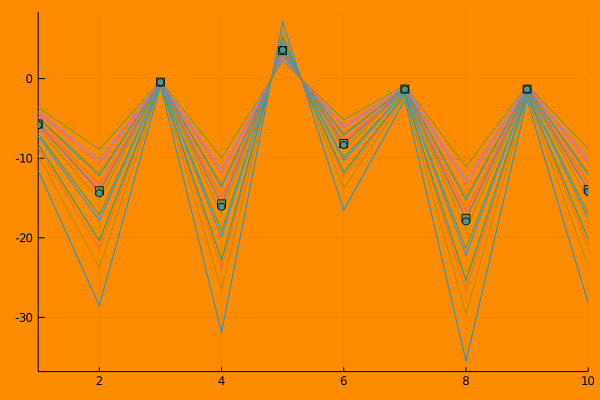

In [32]:
plot(Y, xlims=(1,10),legend=false)
plot!(ũ,shape =:square,xlims=(1,10),legend=false)
scatter!(ufem,bg=:darkorange)